In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health/mental_health_dataset.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the data
df = pd.read_csv('/kaggle/input/mental-health/mental_health_dataset.csv')
df.head()

,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High


## 1. EDA

In [5]:
# Set visualization style
plt.style.use('seaborn')
sns.set_palette('viridis')

In [6]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
age                       0
gender                    0
employment_status         0
work_environment          0
mental_health_history     0
seeks_treatment           0
stress_level              0
sleep_hours               0
physical_activity_days    0
depression_score          0
anxiety_score             0
social_support_score      0
productivity_score        0
mental_health_risk        0
dtype: int64


In [7]:
# Class distribution of target variable
print("\nClass Distribution of mental_health_risk:")
print(df['mental_health_risk'].value_counts(normalize=True))


Class Distribution of mental_health_risk:
mental_health_risk
Medium    0.5892
High      0.2369
Low       0.1739
Name: proportion, dtype: float64


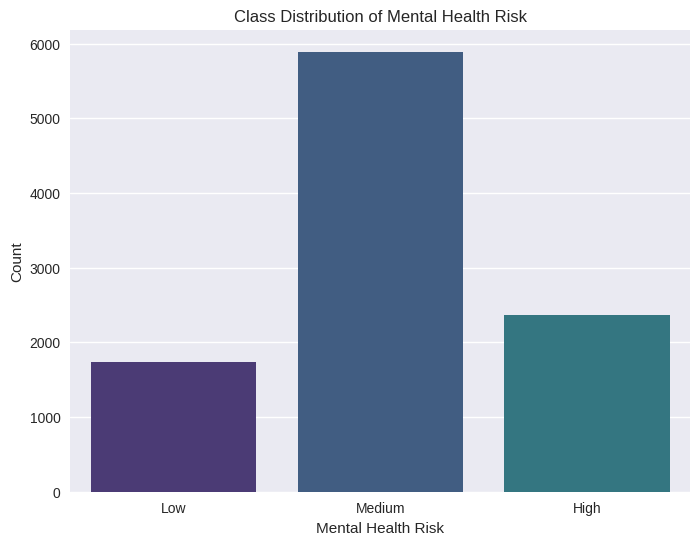

In [8]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='mental_health_risk', data=df, order=['Low', 'Medium', 'High'])
plt.title('Class Distribution of Mental Health Risk')
plt.xlabel('Mental Health Risk')
plt.ylabel('Count')
plt.show()

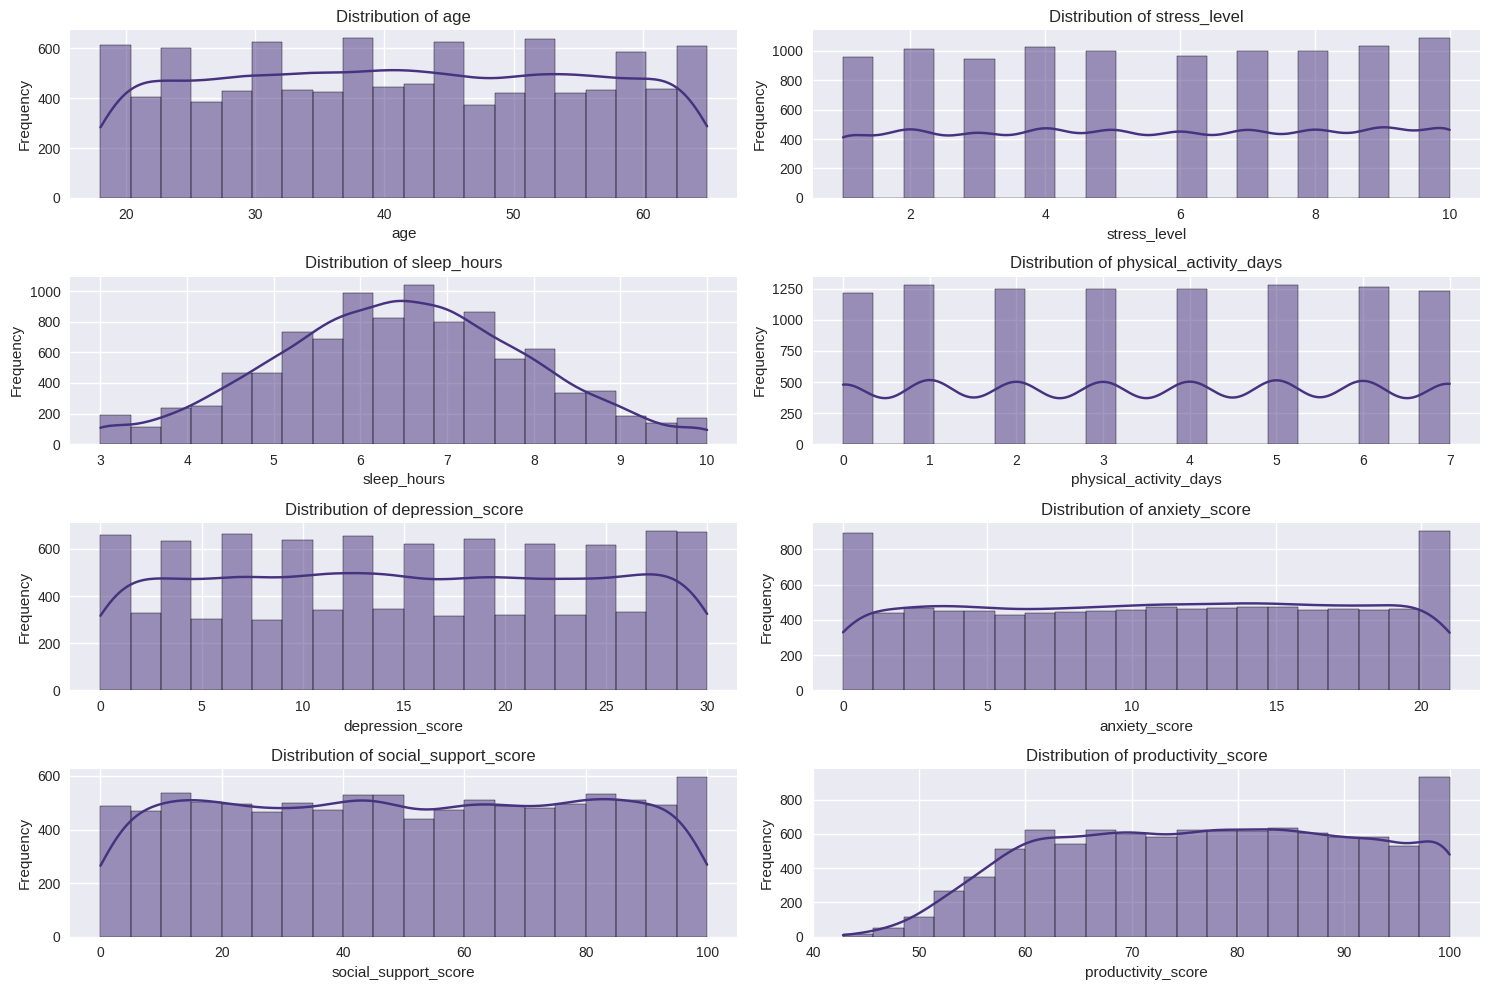

In [9]:
# Visualize numerical feature distributions
num_cols = ['age', 'stress_level', 'sleep_hours', 'physical_activity_days', 
            'depression_score', 'anxiety_score', 'social_support_score', 'productivity_score']
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

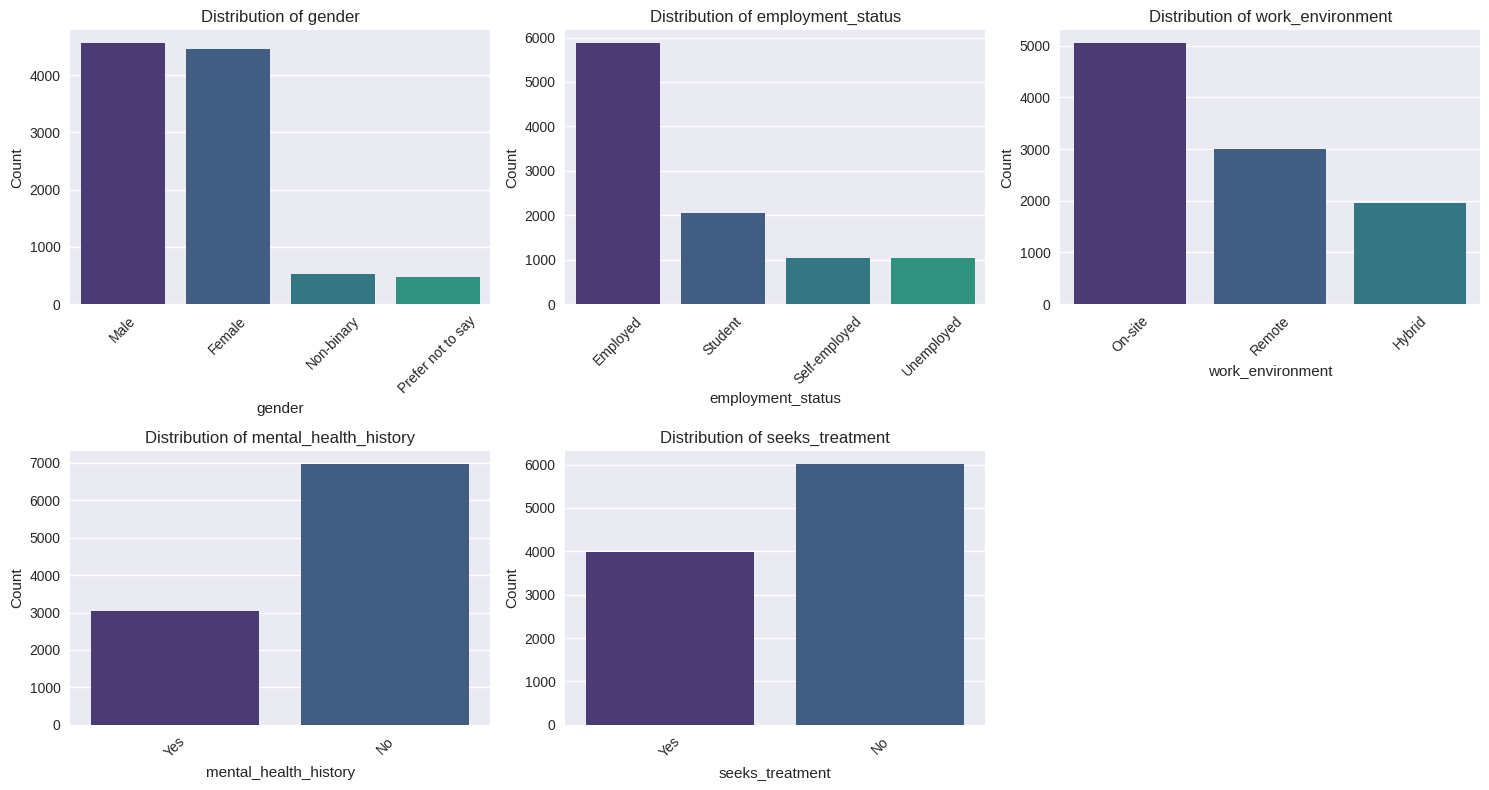

In [10]:
# Visualize categorical feature distributions
cat_cols = ['gender', 'employment_status', 'work_environment', 'mental_health_history', 'seeks_treatment']
plt.figure(figsize=(15, 8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

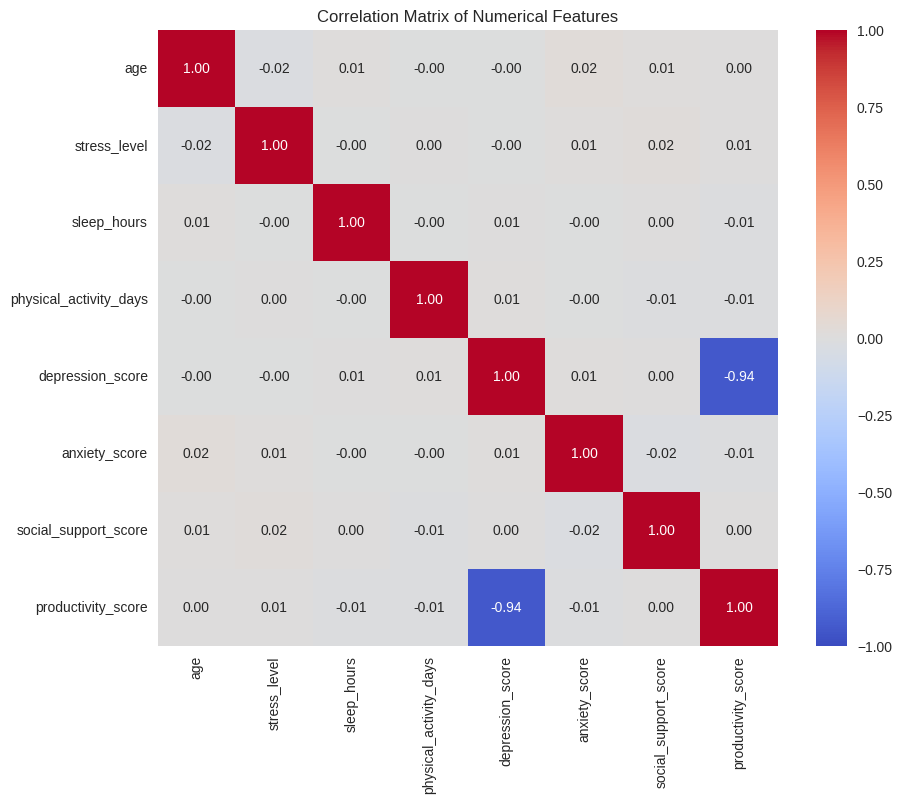

In [11]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

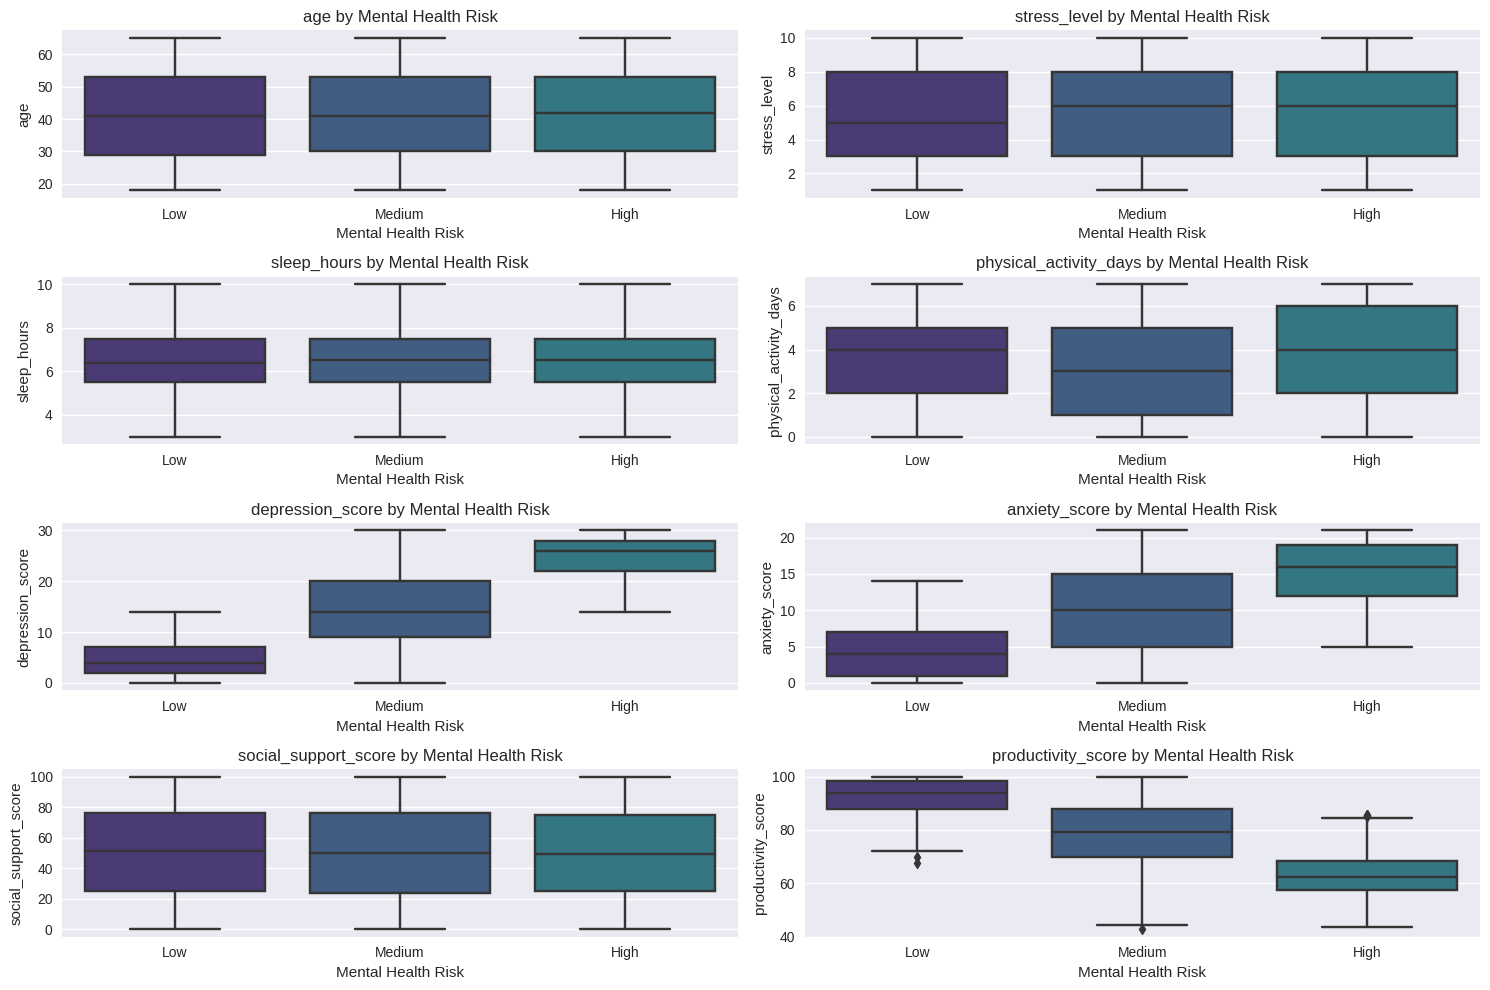

In [12]:
# Boxplots of numerical features by mental_health_risk
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='mental_health_risk', y=col, data=df, order=['Low', 'Medium', 'High'])
    plt.title(f'{col} by Mental Health Risk')
    plt.xlabel('Mental Health Risk')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [13]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip().str.lower()

X = df.drop(columns=["mental_health_risk"])
y_raw = df["mental_health_risk"].astype(str).str.strip().str.lower()

le = LabelEncoder()
y = le.fit_transform(y_raw)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("train:", X_train_raw.shape, "test:", X_test_raw.shape)


train: (8000, 13) test: (2000, 13)


## 2. Preprocessing

In [15]:
# STEP 3: clean, safe, professional preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_cols = [
    'age','stress_level','sleep_hours','physical_activity_days',
    'depression_score','anxiety_score','social_support_score','productivity_score'
]

cat_cols = [
    'gender','employment_status','work_environment',
    'mental_health_history','seeks_treatment'
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop=None, sparse_output=False, handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Fit ONLY on training data
preprocessor.fit(X_train_raw)

# Get correct feature names (important for importance & debugging)
ohe_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
feature_names = num_cols + ohe_names

print("Total processed features:", len(feature_names))
print(feature_names[:10])


Total processed features: 23
['age', 'stress_level', 'sleep_hours', 'physical_activity_days', 'depression_score', 'anxiety_score', 'social_support_score', 'productivity_score', 'gender_female', 'gender_male']


In [16]:
# STEP 4 — Build a clean ML pipeline + Safe Hyperparameter Tuning

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# ML pipeline = preprocessing + model
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

# Hyperparameter search space — efficient, clean, realistic
param_dist = {
    "clf__n_estimators": [100, 200, 300, 400],
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"]
}

# Stratified CV (more reliable for class-based problems)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV on the pipeline (this prevents leakage!)
rnd = RandomizedSearchCV(
    pipe,
    param_dist,
    n_iter=15,
    scoring="f1_macro",   # BEST metric for imbalanced multi-class
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rnd.fit(X_train_raw, y_train)

best_pipeline = rnd.best_estimator_

print("Best CV f1_macro:", rnd.best_score_)
print("Best params:", rnd.best_params_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best CV f1_macro: 0.9506955995109145
Best params: {'clf__n_estimators': 200, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 30}


## 3. Model Training and Evaluation

In [17]:
# STEP 5 — Evaluate the tuned pipeline on the hold-out test set

from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_pipeline.predict(X_test_raw)

print("=== Classification Report on Test Set ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report on Test Set ===
              precision    recall  f1-score   support

        high       0.98      0.94      0.96       474
         low       0.99      0.90      0.94       348
      medium       0.95      0.99      0.97      1178

    accuracy                           0.96      2000
   macro avg       0.97      0.94      0.96      2000
weighted avg       0.96      0.96      0.96      2000


=== Confusion Matrix ===
[[ 444    0   30]
 [   0  313   35]
 [   9    4 1165]]


In [18]:
# STEP 6 — Probability Calibration for better prediction confidence
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

# Extract fitted preprocessor + trained classifier
trained_pre = best_pipeline.named_steps["preprocessor"]
trained_clf = best_pipeline.named_steps["clf"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Transform training data once
X_train_processed = trained_pre.transform(X_train_raw)

# Fit calibrated classifier
calibrated_clf = CalibratedClassifierCV(trained_clf, cv=cv, method="isotonic")
calibrated_clf.fit(X_train_processed, y_train)

# Build final pipeline (preprocessor + calibrated model)
final_pipeline = Pipeline([
    ("preprocessor", trained_pre),
    ("model", calibrated_clf)
])

print("Calibration complete.")


Calibration complete.


In [20]:
# STEP 7 — Save Final Model Artifacts

import joblib
import os

os.makedirs("innersight_artifacts", exist_ok=True)

# Save complete pipeline
joblib.dump(final_pipeline, "innersight_artifacts/innersight_pipeline.pkl")

# Save label encoder
joblib.dump(le, "innersight_artifacts/label_encoder.pkl")

# Save feature names
joblib.dump(feature_names, "innersight_artifacts/feature_names.pkl")

print("Artifacts saved successfully:")
print(os.listdir("innersight_artifacts"))


Artifacts saved successfully:
['innersight_pipeline.pkl', 'feature_names.pkl', 'label_encoder.pkl']


## 5. Feature Importance

In [27]:
print("Length of actual_feature_names:", len(actual_feature_names))

result = permutation_importance(
    final_pipeline,
    X_test_raw,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

print("Length of importances:", len(result.importances_mean))


Length of actual_feature_names: 23
Length of importances: 13


In [28]:
# STEP B — Extract real feature names based on transformed data shape

# transform one sample to get the actual column count
sample_transformed = final_pipeline.named_steps["preprocessor"].transform(X_train_raw.iloc[:1])

print("Actual transformed feature count:", sample_transformed.shape[1])

# now build correct feature names dynamically
real_num = sample_transformed.shape[1]
print("real_num =", real_num)


Actual transformed feature count: 23
real_num = 23


In [33]:
# STEP — Extract RandomForest from best_pipeline BEFORE calibration
rf_model = best_pipeline.named_steps["clf"]

# Extract the feature names again from preprocessor
pre = best_pipeline.named_steps["preprocessor"]

cat_encoder = pre.named_transformers_["cat"]
cat_features = list(cat_encoder.get_feature_names_out(cat_cols))

actual_feature_names = num_cols + cat_features

# Now RF feature importances
rf_importances = rf_model.feature_importances_

import pandas as pd
import matplotlib.pyplot as plt

imp_df = pd.DataFrame({
    "feature": actual_feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

print("Top 10 features:")
print(imp_df.head(10))

# Plot
plt.figure(figsize=(8,6))
plt.barh(imp_df.head(12)["feature"][::-1], imp_df.head(12)["importance"][::-1])
plt.title("RandomForest Feature Importance (Top 12)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("innersight_artifacts/feature_importance.png", dpi=150)
plt.close()

print("\nSaved → innersight_artifacts/feature_importance.png")


Top 10 features:
                       feature  importance
5                anxiety_score    0.304470
4             depression_score    0.295746
7           productivity_score    0.193443
6         social_support_score    0.036011
2                  sleep_hours    0.034123
0                          age    0.032411
1                 stress_level    0.022550
3       physical_activity_days    0.019860
17    work_environment_on-site    0.005077
12  employment_status_employed    0.005061

Saved → innersight_artifacts/feature_importance.png


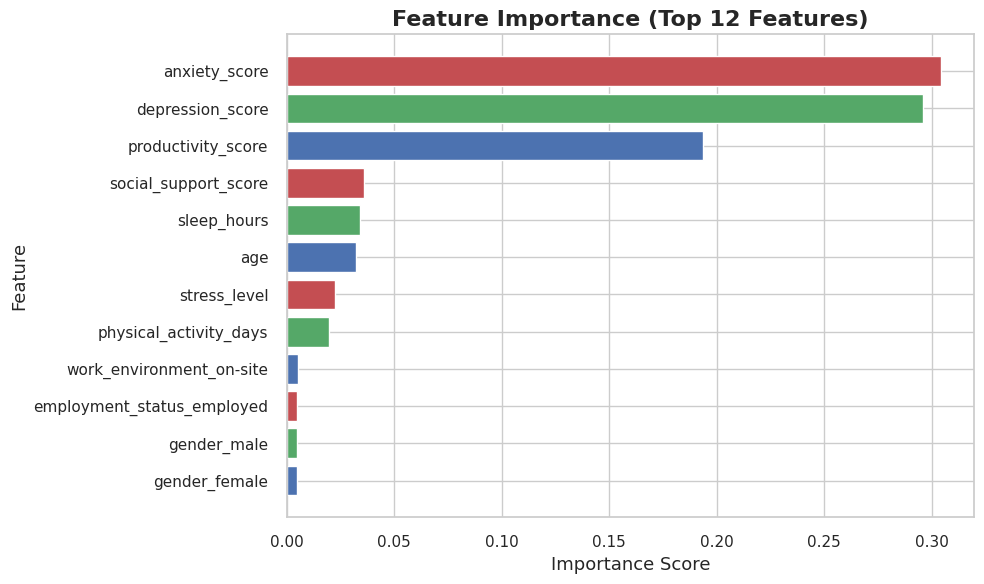

In [35]:
#feature importance plot

import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean whitegrid theme
sns.set_theme(style="whitegrid")

# Select top 12
top_df = imp_df.head(12).iloc[::-1]

plt.figure(figsize=(10, 6))
bars = plt.barh(top_df["feature"], top_df["importance"],
                color=sns.color_palette(["#4c72b0", "#55a868", "#c44e52"], n_colors=12))

plt.title("Feature Importance (Top 12 Features)", fontsize=16, fontweight="bold")
plt.xlabel("Importance Score", fontsize=13)
plt.ylabel("Feature", fontsize=13)

# Make ticks prettier
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()


In [36]:
# STEP 9 — SHAP Explainability (Global & Local)

import shap

# 1. Extract the trained RandomForest (before calibration)
rf_model = best_pipeline.named_steps["clf"]

# 2. Transform the test set using the pipeline's preprocessor
X_test_transformed = best_pipeline.named_steps["preprocessor"].transform(X_test_raw)

# 3. Build SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# 4. Compute SHAP values for test sample
shap_values = explainer.shap_values(X_test_transformed)

print("SHAP values computed successfully.")


SHAP values computed successfully.


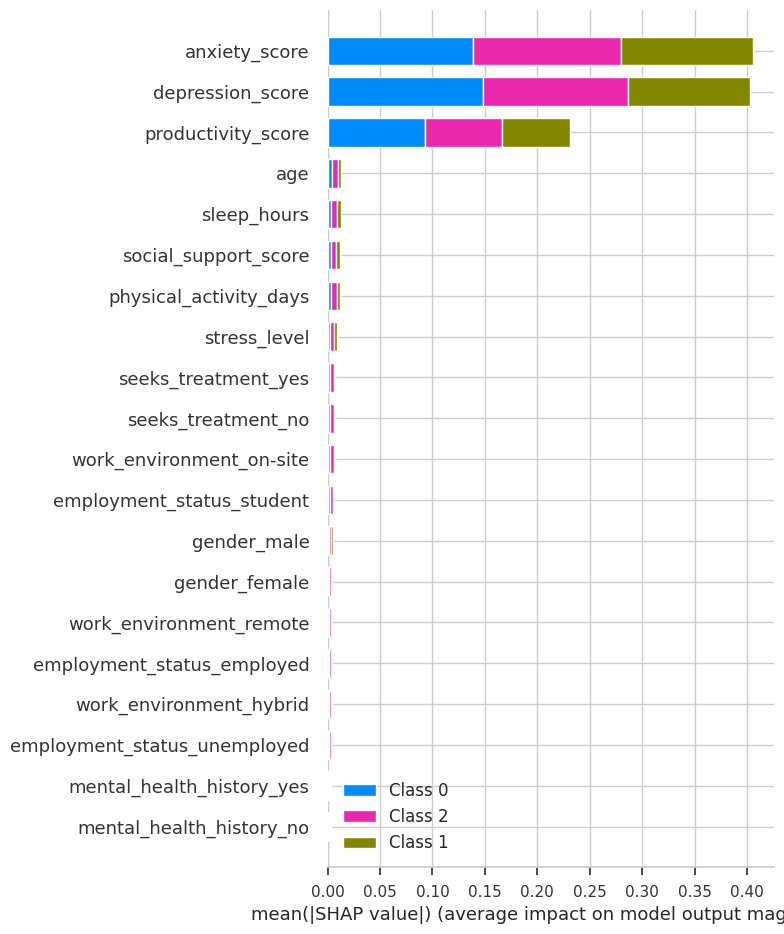

In [37]:
# SHAP Summary Plot (Global Explanation)
shap.summary_plot(shap_values, X_test_transformed, feature_names=actual_feature_names)


In [39]:
# Save SHAP force plot as HTML
shap.save_html("innersight_artifacts/force_plot.html",
               shap.force_plot(explainer.expected_value[1],
                                shap_values[1][0,:],
                                feature_names=actual_feature_names))


In [42]:
import os
os.listdir("/kaggle/working/")


['.virtual_documents', 'innersight_artifacts']

In [43]:
from IPython.display import FileLink, FileLinks

FileLinks('.')


./innersight_artifacts/
  innersight_pipeline.pkl
  feature_names.pkl
  label_encoder.pkl
  force_plot.html
  feature_importance.png